In [2]:
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skbio.stats.composition import clr, centralize
from scipy.spatial.distance import euclidean
#deicode
from deicode.optspace import OptSpace
from deicode.utils import get_enriched_labels,get_mean_abundance,get_lowest_level
from deicode.preprocessing import rclr,inverse_rclr
from skbio.stats.composition import clr,closure,centralize

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
%matplotlib inline

def plot_clusters(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    idx = md['Cluster'] == 'Cluster 1'
    ax.scatter(samples.loc[idx, 'PC1'], samples.loc[idx, 'PC2'], label='Cluster 1')   
    ax.scatter(samples.loc[~idx, 'PC1'], samples.loc[~idx, 'PC2'], label='Cluster 2')    
    
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=18)    
    ax.set_xlabel('PC1', fontsize=18)
    return ax

In [4]:
#example dataset
simulation=pd.read_csv('cluster_models/simulation_subsampled_noisy.csv', index_col=[0,1,2,3])
example_data=simulation.loc[(2,20,2000,),:]
example_data_clr=rclr().fit_transform(example_data.copy().T)
example_data_clr_df=pd.DataFrame(example_data_clr.T,index=example_data.index,columns=example_data.columns)
opt=OptSpace(rank=2,iteration=5,tol=1e-5).fit(example_data_clr)


#ordination!

from sklearn.cluster import KMeans

u=opt.sample_weights
k=opt.s
v=pd.DataFrame(opt.feature_weights)
v.index=['OTU_'+str(x) for x in v.index]
feature_loading=v.copy()
feature_loading = feature_loading.sort_values(by=1)

U=pd.DataFrame(u)
U.index=['sample_'+str(x) for x in U.index]
U.columns=['PC2','PC1']
mapping={**{'sample_'+str(x):['Cluster 1'] for x in range(int(U.shape[0]/int(2)))},
        **{'sample_'+str(x):['Cluster 2'] for x in range(int(U.shape[0]/int(2))
                                                      ,int(U.shape[0]))}}
mapping=pd.DataFrame(mapping,index=['Cluster']).T
life_stage = mapping['Cluster'].sort_values()

#get centroid
kmeans = KMeans(n_clusters=2)
kmeans.fit(u)

centroids = kmeans.cluster_centers_


# fake taxa
cols=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species','taxonomy']
index_=example_data.index
taxonomy=pd.DataFrame(np.array([i[0]+'__'+x.replace('OTU_','microbe_') 
                                for x in index_ for i in cols]).reshape(len(index_),len(cols))
                      ,index=index_,columns=cols)

cutoff_=2.9
features=get_enriched_labels(feature_loading.copy(),cutoff=cutoff_)
mean_abundances=get_mean_abundance(example_data.T,mapping,features,'Cluster')
index_level_tax=get_lowest_level(taxonomy,features,default_highest=-6)

#group by lowest level
mean_abundances.index=[index_level_tax[i] for i in mean_abundances.index]
mean_abundances=mean_abundances.groupby(mean_abundances.index).sum()


for this we will just plot the pieces for the ms

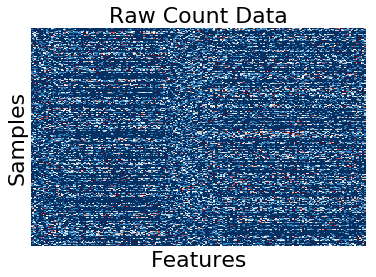

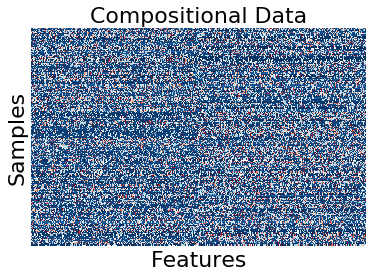

In [5]:
sns.heatmap(example_data.sample(frac=1).as_matrix(),robust=True
            , xticklabels=False, yticklabels=False,
           cbar=False,cmap='RdBu_r')
plt.xlabel('Features', fontsize=22)
plt.ylabel('Samples', fontsize=22)
plt.title('Raw Count Data',fontsize=22)
plt.show()

sns.heatmap(pd.DataFrame(example_data_clr).sample(frac=1).as_matrix(),robust=True
            , xticklabels=False, yticklabels=False,
           cbar=False,cmap='RdBu_r')
plt.xlabel('Features', fontsize=22)
plt.ylabel('Samples', fontsize=22)
plt.title('Compositional Data',fontsize=22)
plt.show()


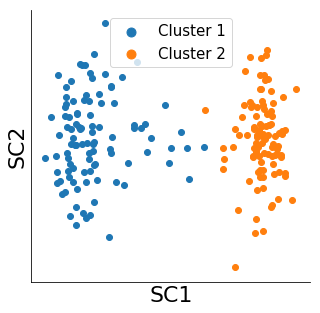

In [6]:
fig,ax = plt.subplots(1,1,figsize=(5,5))


plot_clusters(U,mapping,ax)
bias = example_data.as_matrix().mean(axis=0)
bbox_props = dict(fc="w",facecolor='black', ec="0.5", alpha=0.8)
ax.set_xlabel('SC1',fontsize=22)
ax.set_ylabel('SC2',fontsize=22)
ax.legend(loc=9,prop={'size':15},markerscale=1.5)
plt.show()


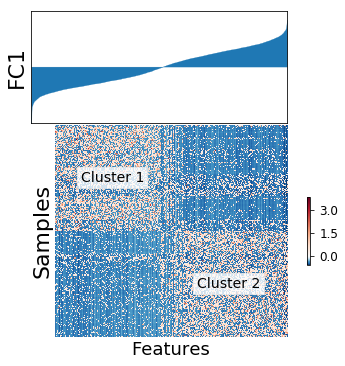

In [7]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('seaborn-paper')

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(5, 6), facecolor='white')
gs = gridspec.GridSpec(23, 60)
ax_map = plt.subplot(gs[8:23, 5:55])
ax_bar = plt.subplot(gs[0:8, :55])
ax_cbar = plt.subplot(gs[8:23, 55:])

ind = np.arange(feature_loading.shape[0])
ax_bar.stackplot(ind, feature_loading[1],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[1].min(), feature_loading[1].max()])
ax_bar.set_yticks([])
ax_bar.set_xticks([])
ax_bar.set_ylim([-3, 3])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('FC1', fontsize=22)
ax_bar.set_yticks([])

ax_bar.tick_params(labelsize=12)

sorted_df = example_data.T.reindex(index=life_stage.index, columns=feature_loading.index)
sorted_df = sorted_df.loc[:, sorted_df.sum(axis=0) > 10] #make clusters more evident 
img = ax_map.imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                    norm=MidpointNormalize(midpoint=0.),
                    interpolation='nearest', cmap='RdBu_r')


bbox_props = dict(fc="w",facecolor='black', ec="0.5", alpha=0.8)
ax_map.text(3000., 150,'Cluster 2', ha="center", va="center", size=14,bbox=bbox_props)
bbox_props = dict(fc="w",facecolor='black', ec="0.5", alpha=0.8)
ax_map.text(1000., 50,'Cluster 1', ha="center", va="center", size=14,bbox=bbox_props)

ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_xlabel('Features', fontsize=18)
ax_map.set_ylabel('Samples',labelpad=2, fontsize=22)
ax_map.spines['right'].set_visible(False)
ax_map.spines['top'].set_visible(False)
ax_map.spines['bottom'].set_visible(False)
ax_map.spines['left'].set_visible(False)
ax_map.grid()

cbar = fig.colorbar(img, ax=ax_cbar) 
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])
ax_cbar.axis('off')
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])



plt.show()



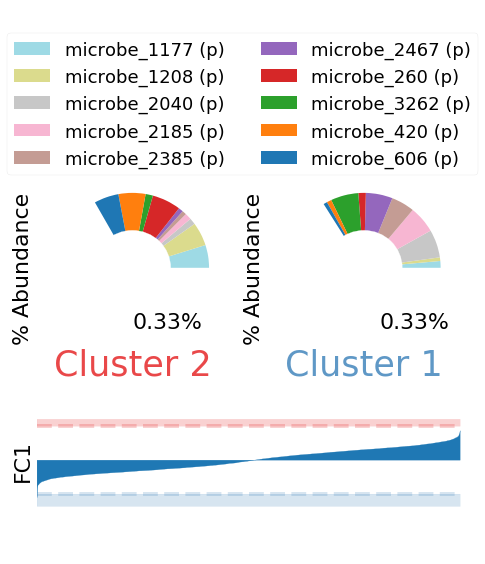

In [8]:
import math
fig = plt.figure(figsize=(8, 10), facecolor='white')
gs = gridspec.GridSpec(20, 58)

ax_legend = plt.subplot(gs[0:4, :55])
ax_bar = plt.subplot(gs[13:20, :55])
ax_group1 = plt.subplot(gs[6:13, :25])
ax_group2 = plt.subplot(gs[6:13, 30:55])

ind = np.arange(feature_loading.shape[0])
ax_bar.stackplot(ind, feature_loading[1],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
ax_bar.set_xticks([])
ax_bar.axhline(cutoff_,lw=4,ls='--',color="#e41a1c",alpha=.2)
ax_bar.axhline(-cutoff_,lw=4,ls='--',color="#377eb8",alpha=.2)
ax_bar.fill_between(ind, cutoff_,feature_loading[0].max(), color="#e41a1c",alpha=.2)  
ax_bar.fill_between(ind, -cutoff_,feature_loading[0].min(), color="#377eb8",alpha=.2)  
ax_bar.set_ylim([-8, 8])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('FC1', fontsize=22)
ax_bar.set_yticks([])
ax_bar.tick_params(labelsize=12)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['left'].set_visible(False)

locs=[(.0,-.8),(.2,-.8)]
percs=[str(x)[:4]+'%' for x in list(mean_abundances.sum())]
for (count_,group_),ax,cols_ in zip(enumerate(mean_abundances.columns[::-1]),
                             [ax_group1,ax_group2]
                                   ,['#e41a1c','#377eb8']):
    all_pie=mean_abundances.copy()
    
    all_pie[group_]=all_pie[group_]
    
    # Create a circle for the center of the plot
    my_circle=plt.Circle( (0,0), 0.5, color='white')

    all_pie[group_].T.plot.pie(ax=ax,
                                    labels=['' for x in mean_abundances[group_].values],
                                   colormap='tab20_r')

    ax.set_ylabel('% Abundance',fontsize=22)
    ax.add_artist(my_circle)
    ax.annotate(percs[count_], locs[count_],fontsize=22)
    ax.set_title(group_,fontsize=35,y=-.10,color=cols_,alpha=.8)
    
ax_group1.legend(labels=all_pie.index,title=""
                 , loc=2,prop={'size':18}
                 ,bbox_to_anchor=(-0.2, 1.8),
                ncol=math.floor(np.sqrt(len(mean_abundances.index)))-1) 

ax_legend.grid()
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.axis('off')
ax_legend.grid()
ax_legend.set_xticks([])
ax_legend.set_yticks([])
plt.show()
